Необходимо разработать программу, классифицирующую людей по полу. Для классификации необходимо использовать сверточную нейронную сеть. Поэкспериментировать с параметрами и структурой нейронной сети.

## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/dataset/archive.zip

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report

## Data preprocessing

In [ ]:
traingen = Imgen(rescale=1./255, 
                shear_range = 0.2, 
                zoom_range = 0.2,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                fill_mode="nearest",
                validation_split=0.15)


testgen = Imgen(rescale=1./255)

In [ ]:
trainds = traingen.flow_from_directory("/content/Training",
                                      target_size=(96,96),
                                       seed=123,
                                       batch_size=32,
                                       subset="training"
                                      )
valds = traingen.flow_from_directory("/content/Training",
                                      target_size=(96,96),
                                       seed=123,
                                       batch_size=32,
                                       subset="validation"
                                      )
testds = testgen.flow_from_directory("/content/Validation",
                                    target_size=(96,96),
                                    seed=123,
                                    batch_size=32,
                                    shuffle=False)

Found 39959 images belonging to 2 classes.
Found 7050 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


## Visualisation

In [ ]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 31.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=78bdb28adf4d3e18c12bbf18df4a2dfd1088110ea93f97e191128d1f5735f888
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=d1806f4050bbe5df6011ebe6503333910f413102ba5d55757d521f3f89e3c337
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap

In [ ]:
c = trainds.class_indices
classes = list(c.keys())
classes

['female', 'male']

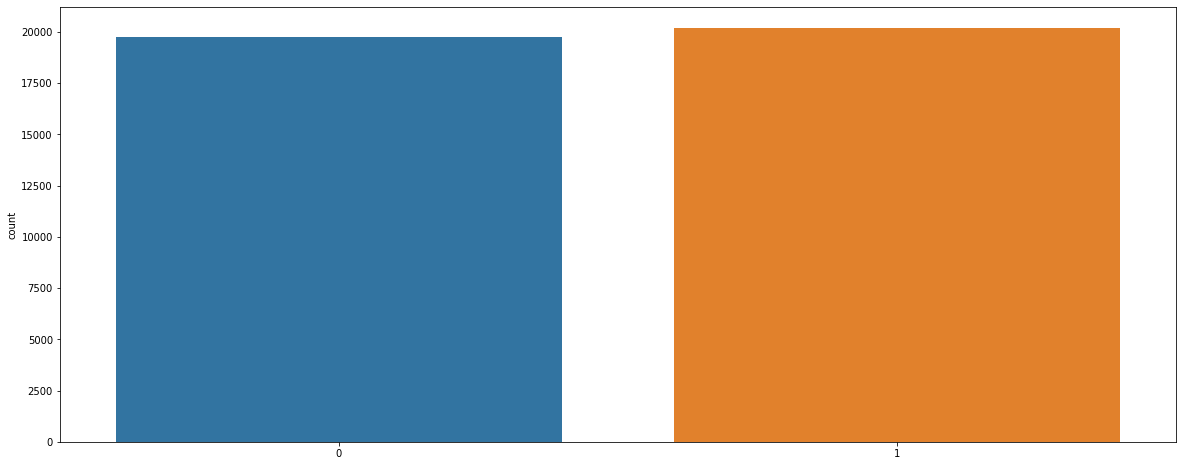

In [ ]:
plt.figure(figsize=[20,8])
sns.countplot(x=trainds.classes);

In [ ]:
um = umap.UMAP()
umaped_data = um.fit_transform(valds)

plt.scatter(umaped_data[:, 0], umaped_data[:, 1], s = 6)

# НЕ РАБОТАЕТ, ПОТОМУ ЧТО КОЛАБУ НЕ ХВАТАЕТ ОЗУ НА ОБРАБОТКУ, ДОВОЛЬСТВУЕМСЯ ТЕМ, ЧТО БЫЛО ВЫШЕ...

In [ ]:
my_calls = [EarlyStopping(monitor="val_accuracy",patience=3),
            ModelCheckpoint("Model.h5", verbose= 1, save_best_only=True)]

## Functions

In [ ]:
def plot(hist):
  plt.figure(figsize=(15,6))

  plt.subplot(1,2,1)
  plt.plot(hist.epoch, hist.history['accuracy'],label = 'Training')
  plt.plot(hist.epoch, hist.history['val_accuracy'],label = 'Validation')

  plt.title("Accuracy")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(hist.epoch, hist.history['loss'],label = 'Training')
  plt.plot(hist.epoch, hist.history['val_loss'],label = 'Validation')

  plt.title("Loss")
  plt.legend()
  plt.show()

In [ ]:
def report(model, testds):
  pred = model.predict(testds,verbose=1)
  predicted,confidence = [np.argmax(i) for i in pred], [np.round((max(i)*100),2) for i in pred]
  y_test = testds.classes
  print(classification_report(y_test, predicted))
  plt.figure(figsize=[12,6])
  hm = sns.heatmap(confusion_matrix(y_test, predicted), annot=True, fmt="d", cmap="Blues")
  hm.set(xlabel='predicted', ylabel='true')

## CNN #1

In [ ]:
image_input = Input(shape=(96,96,3))

x = Conv2D(32,(3,3),activation = "relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64,(3,3),activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128,(3,3),activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(2,activation="softmax")(x)

model = Model(image_input,image_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496 

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
hist = model.fit(trainds,epochs=20,validation_data=valds,callbacks=my_calls)

Epoch 1/20
1249/1249 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7942
Epoch 1: val_loss improved from inf to 0.33499, saving model to Model.h5
1249/1249 [==============================] - 139s 109ms/step - loss: 0.4719 - accuracy: 0.7942 - val_loss: 0.3350 - val_accuracy: 0.8521
Epoch 2/20
1249/1249 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.8993
Epoch 2: val_loss improved from 0.33499 to 0.21667, saving model to Model.h5
1249/1249 [==============================] - 124s 99ms/step - loss: 0.2473 - accuracy: 0.8993 - val_loss: 0.2167 - val_accuracy: 0.9133
Epoch 3/20
1249/1249 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9190
Epoch 3: val_loss improved from 0.21667 to 0.19176, saving model to Model.h5
1249/1249 [==============================] - 125s 100ms/step - loss: 0.2102 - accuracy: 0.9190 - val_loss: 0.1918 - val_accuracy: 0.9265
Epoch 4/20
1249/1249 [==============================] - ETA: 0s - los

In [ ]:
model.evaluate(testds)

365/365 [==============================] - 7s 20ms/step - loss: 0.2336 - accuracy: 0.9137


[0.23357044160366058, 0.9137265086174011]

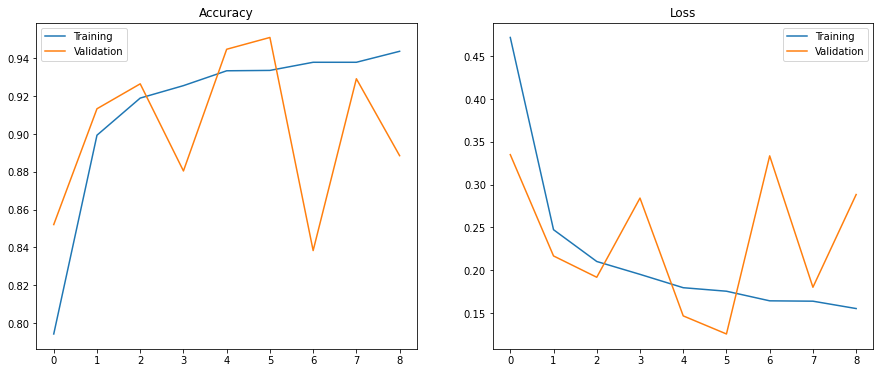

In [ ]:
plot(hist)

365/365 [==============================] - 7s 18ms/step
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      5841
           1       1.00      0.83      0.91      5808

    accuracy                           0.91     11649
   macro avg       0.93      0.91      0.91     11649
weighted avg       0.93      0.91      0.91     11649



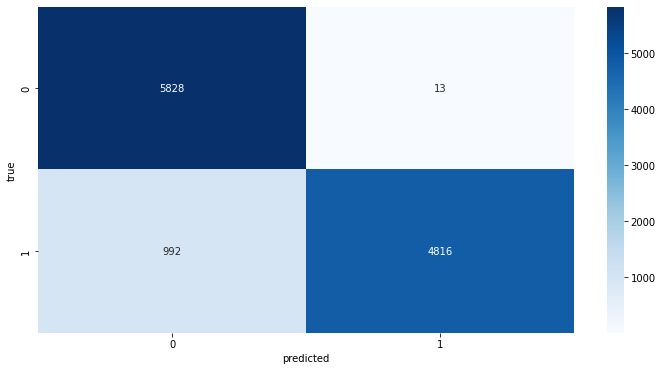

In [ ]:
report(model, testds)

## CNN #2

In [ ]:
image_input = Input(shape=(96,96,3))

x = Conv2D(32,(3,3),activation = "relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64,(3,3),activation = "relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(64,activation="sigmoid")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(2,activation="softmax")(x)

model = Model(image_input,image_output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        1849

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
hist = model.fit(trainds,epochs=20,validation_data=valds,callbacks=my_calls)

Epoch 1/20
1249/1249 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.6614
Epoch 1: val_loss improved from inf to 0.53750, saving model to Model.h5
1249/1249 [==============================] - 124s 99ms/step - loss: 0.6670 - accuracy: 0.6614 - val_loss: 0.5375 - val_accuracy: 0.7447
Epoch 2/20
1249/1249 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7411
Epoch 2: val_loss did not improve from 0.53750
1249/1249 [==============================] - 125s 100ms/step - loss: 0.5277 - accuracy: 0.7411 - val_loss: 0.5456 - val_accuracy: 0.7325
Epoch 3/20
1249/1249 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7557
Epoch 3: val_loss improved from 0.53750 to 0.48164, saving model to Model.h5
1249/1249 [==============================] - 122s 98ms/step - loss: 0.5071 - accuracy: 0.7557 - val_loss: 0.4816 - val_accuracy: 0.7746
Epoch 4/20
1249/1249 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7713
Ep

In [ ]:
model.evaluate(testds)

365/365 [==============================] - 8s 22ms/step - loss: 0.5550 - accuracy: 0.6981


[0.555040180683136, 0.6980856657028198]

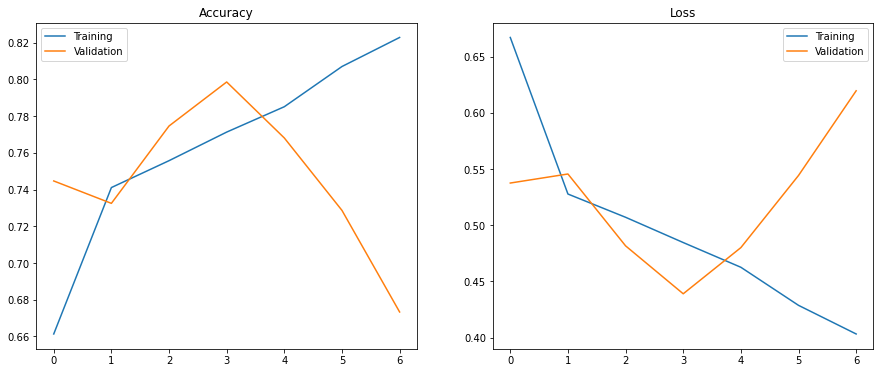

In [ ]:
plot(hist)

365/365 [==============================] - 7s 18ms/step
              precision    recall  f1-score   support

           0       0.63      0.99      0.77      5841
           1       0.97      0.41      0.57      5808

    accuracy                           0.70     11649
   macro avg       0.80      0.70      0.67     11649
weighted avg       0.80      0.70      0.67     11649



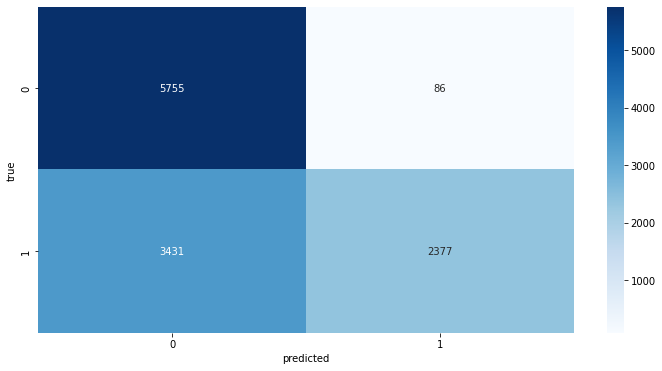

In [ ]:
report(model, testds)